In [151]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from Functionality import Reduce_numerical_columns,Reduce_text_change,Reduce_event,Reduce_activity,getX_Y,getModel,performCrossValidation,makePredictions,perfromGridSearch,performKfoldScore,Aggregation,ConcatAlongId
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
import re
import copy
import string
import seaborn as sns

In [2]:
# Directories Where the data is present
train_logs_directory = os.path.join("Data","train_logs.csv")
train_scores_directory = os.path.join("Data","train_scores.csv")
test_logs_directory = os.path.join("Data","test_logs.csv")

# Loading Dataset

In [3]:
# following the naming convention that everything related
# to train will be followed by train_ and everything followed by test will be followed by test_
train_logs_df = pd.read_csv(train_logs_directory)
test_logs_df = pd.read_csv(test_logs_directory)
train_scores_df = pd.read_csv(train_scores_directory)

In [4]:
train_df = pd.merge(train_logs_df,train_scores_df,on = "id",how = "inner")
train_df.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,score
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,3.5
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,3.5
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,3.5


# Exploratory Data Analysis

In [5]:
# No null values are present
# train_logs_df.isnull().sum()

In [6]:
train_df.dtypes

id                  object
event_id             int64
down_time            int64
up_time              int64
action_time          int64
activity            object
down_event          object
up_event            object
text_change         object
cursor_position      int64
word_count           int64
score              float64
dtype: object

In [7]:
train_df.columns

Index(['id', 'event_id', 'down_time', 'up_time', 'action_time', 'activity',
       'down_event', 'up_event', 'text_change', 'cursor_position',
       'word_count', 'score'],
      dtype='object')

In [8]:
train_df["up_event"].unique()

array(['Leftclick', 'Shift', 'q', 'Space', 'Backspace', '.', ',', 'Enter',
       'ArrowLeft', "'", ';', 'ArrowRight', '-', '?', 'Tab', '"',
       'ArrowUp', 'ArrowDown', 'm', 'Rightclick', 'i', 'o', 't', '=', 'a',
       'CapsLock', 'Control', 'c', 'v', '/', 'Delete', ':', 'z', '[', '$',
       '(', ')', '+', 'Home', 'End', '\\', 'Meta', '*', '&',
       'AudioVolumeMute', 'x', '!', 'Insert', 'MediaPlayPause', 'w',
       'NumLock', '%', 'V', 'b', '>', 'Alt', 'AudioVolumeUp',
       'ContextMenu', 'AudioVolumeDown', 'n', 'e', '<', 'PageDown', ']',
       'Middleclick', '@', 'F12', 'u', 'j', 's', '\x96', 'Dead', 'y', '{',
       'ScrollLock', '¿', 'p', 'Process', '}', 'MediaTrackPrevious',
       'MediaTrackNext', 'F3', '^', 'Unidentified', 'Cancel', 'h', '2',
       'd', 'r', '`', '\x9b', 'f', 'g', '#', '~', 'PageUp', 'l', 'T', 'A',
       'S', 'ModeChange', '_', 'Escape', 'F11', 'Unknownclick',
       'AltGraph', 'F10', 'F15', 'Clear', 'OS', 'C', 'Ä±', 'M', '|',
       'â\x80\x93', 

In [9]:
# Highly skewed dataset
train_df["activity"].unique()

array(['Nonproduction', 'Input', 'Remove/Cut', 'Replace',
       'Move From [284, 292] To [282, 290]',
       'Move From [287, 289] To [285, 287]',
       'Move From [460, 461] To [465, 466]', 'Paste',
       'Move From [905, 1314] To [907, 1316]',
       'Move From [565, 743] To [669, 847]',
       'Move From [669, 847] To [565, 743]',
       'Move From [1041, 1121] To [1496, 1576]',
       'Move From [1455, 1557] To [1323, 1425]',
       'Move From [2268, 2275] To [2247, 2254]',
       'Move From [213, 302] To [902, 991]',
       'Move From [0, 158] To [234, 392]',
       'Move From [460, 465] To [925, 930]',
       'Move From [810, 906] To [816, 912]',
       'Move From [186, 187] To [184, 185]',
       'Move From [140, 272] To [299, 431]',
       'Move From [114, 140] To [272, 298]',
       'Move From [1386, 1450] To [1445, 1509]',
       'Move From [442, 524] To [296, 378]',
       'Move From [408, 414] To [390, 396]',
       'Move From [1144, 1147] To [1142, 1145]',
       'Move 

In [10]:
train_df["activity"]

0          Nonproduction
1          Nonproduction
2          Nonproduction
3                  Input
4                  Input
               ...      
8405893    Nonproduction
8405894    Nonproduction
8405895          Replace
8405896    Nonproduction
8405897            Input
Name: activity, Length: 8405898, dtype: object

In [11]:
train_df.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,score
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,3.5
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,3.5
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,3.5


In [12]:
train_df["text_change"]

0          NoChange
1          NoChange
2          NoChange
3                 q
4                 q
             ...   
8405893    NoChange
8405894    NoChange
8405895      q => q
8405896    NoChange
8405897           .
Name: text_change, Length: 8405898, dtype: object

# Working on the essay part and adding more features

In [153]:
def EssayGenerator(temp_df):
    essay_text = ""
    for index,i in temp_df.iterrows():
    
        cursor_position = i["cursor_position"]
    
        if i["activity"] == "Input":
            essay_text += i["text_change"]
            continue
    
        if i["activity"] == "Replace":
            # cursor position is after the operation
            replace_text = i["text_change"].split(" => ") # replace_text = ["original word" , "newWord"]
            essay_text = essay_text[:cursor_position - len(replace_text[1])] + replace_text[1] + essay_text[cursor_position - len(replace_text[1]) + len(replace_text[0]):]
            continue

        # :asdfewafdsfewafdsf weafdsfwe  dfsafewafds weadsfwe afsd wasd fdf wea dsfdeswaewfr sd 

        if i["activity"] == "Remove/Cut":
            remove_word = i["text_change"]
            essay_text = essay_text[:cursor_position] + essay_text[cursor_position+ len(remove_word):]
            continue
    
        
        if i["activity"] == "Paste":
            text = i["text_change"]
            essay_text = essay_text[:cursor_position-len(text)] + text + essay_text[cursor_position - len(text):]
            continue
    
        if i["activity"].startswith("Move"):
            text = i["activity"]
            matches = re.findall(r'\[.*?\]', text)
            arrays = [eval(match) for match in matches]
    
            # Move the text from array[0] to array[1] postion 
            if arrays[0][0] < arrays[1][0]:
                # Here movement is done from the lower of the text to the higher part of the tex+t
                essay_text = essay_text[:arrays[0][0]] + essay_text[arrays[0][1] : arrays[1][0]] + essay_text[arrays[0][0] : arrays[0][1]] + essay_text[arrays[1][0]:]
            else:
                # Here movement is done from the higher end to the lower end 
                essay_text = essay_text[:arrays[1][0]] + essay_text[arrays[0][0]: arrays[0][1]] + essay_text[arrays[1][0]: arrays[0][0]] + essay_text[arrays[0][1]:]
            continue
    return essay_text

def count_punctuations(sentence):
    punctuation_count = sum(1 for char in sentence if char in string.punctuation)
    return punctuation_count

In [109]:
def GetEssay(train_logs_df,train_postprocessed_df):
    temp_df = copy.deepcopy(train_logs_df)
    essay = temp_df.groupby("id").apply(lambda x : EssayGenerator(x))
    final_df = pd.DataFrame(essay).reset_index()
    final_df.columns = ["_id","essay"]
    final_df = pd.merge(final_df,train_postprocessed_df,on = "_id",how = "inner")
    
    # return final_df

    #Adding essay Level features
    final_df["number_of_commas_in_essay"] = final_df["essay"].str.count(",")

    #Adding the sentence length
    #TODO: split the sentence based on the !,?
    #TODO: average length of sentence
    #TODO: 
    sentence_level_features = {
        "number_of_sentence":[],
        "max_length_sentence":[],
        "min_length_sentence":[],
        "max_punchuation_sentence":[],
        "max_number_of_spaces" : [],
        "min_number_of_spaces" : [],
    
        
    }
    for row in final_df["essay"].str.split("."):
        # Iterating through the sentences rowise
        # TODO: remove \n and also split on the ? and !
        sentence_level_features["number_of_sentence"].append(len(row))
        sentence_level_features["max_length_sentence"].append(len(max(row,key = lambda s : len(s))))
        sentence_level_features["min_length_sentence"].append(len(min(row,key = lambda s : len(s))))
        sentence_level_features["max_number_of_spaces"].append(len(max(row,key = lambda s : len(s.split()))))
        sentence_level_features["min_number_of_spaces"].append(len(min(row,key = lambda s : len(s.split())))) 
        sentence_level_features["max_punchuation_sentence"].append(len(max(row,key = lambda s : count_punctuations(s))))

    sentence_level_df = pd.DataFrame(sentence_level_features)
    final_df = pd.concat([final_df,sentence_level_df],axis = 1)

    # Adding word level features 
    word_level_features = {
        "max_word_length" : [],
        "min_word_length" : [],
        "average_word_length":[],
        "number_of_words" : [],
    }
    for row in final_df["essay"].str.split():
        if len(row) == 0:
            continue
        word_level_features["max_word_length"].append(len(max(row,key = lambda s: len(s))))
        word_level_features["min_word_length"].append(len(min(row,key = lambda s: len(s))))
    
        average = sum([len(s) for s in row]) / len(row)
    
        word_level_features["average_word_length"].append(average)
        word_level_features["number_of_words"].append(len(row))
    

    word_level_df = pd.DataFrame(word_level_features)
    final_df = pd.concat([final_df,word_level_df],axis = 1)

    # Adding paragraph level features
    paragraph_level_features = {
        "number_of_paragraphs" : [],
        "max_length_paragraphs" : [],
        "min_length_paragraphs" : [],
        "max_number_of_spaces_paragraph" : [],
    }
    for row in final_df["essay"].str.split("\n"):
        non_empty_lines = [line for line in row if line]
        paragraph_level_features["number_of_paragraphs"].append(len(non_empty_lines))
        paragraph_level_features["max_length_paragraphs"].append(len(max(non_empty_lines,key = lambda s: len(s))))
        paragraph_level_features["min_length_paragraphs"].append(len(max(non_empty_lines,key = lambda s: len(s))))
        paragraph_level_features["max_number_of_spaces_paragraph"].append(len(max(non_empty_lines,key = lambda s: len(s.split())).split())-1)

    paragraph_level_df = pd.DataFrame(paragraph_level_features)
    final_df = pd.concat([final_df,paragraph_level_df],axis = 1)
    
    return final_df

In [156]:
train_logs_df.groupby("id")["up_time"].shift(3)

0                NaN
1                NaN
2                NaN
3             4557.0
4             4962.0
             ...    
8405893    2061331.0
8405894    2062125.0
8405895    2062555.0
8405896    2064440.0
8405897    2064497.0
Name: up_time, Length: 8405898, dtype: float64

In [157]:
train_logs_df["up_time"].shift(3)

0                NaN
1                NaN
2                NaN
3             4557.0
4             4962.0
             ...    
8405893    2061331.0
8405894    2062125.0
8405895    2062555.0
8405896    2064440.0
8405897    2064497.0
Name: up_time, Length: 8405898, dtype: float64

In [166]:
train_logs_df["down_time"] - train_logs_df["up_time"].shift(3)

0               NaN
1               NaN
2               NaN
3          102129.0
4          102234.0
             ...   
8405893      2613.0
8405894      2372.0
8405895      2102.0
8405896      4746.0
8405897      5568.0
Length: 8405898, dtype: float64

# Data Filteration

In [121]:
# Splitting the dataset between the categorical and numerical values
num_attributes = ["id","event_id","down_time","up_time","action_time","cursor_position","word_count"]
cat_attributes = ["activity","down_event","up_event","text_change"]

In [122]:
processing = ColumnTransformer([
    ("RemoveId",make_pipeline(Reduce_numerical_columns()),num_attributes),
     ("ValueSum",make_pipeline(Reduce_text_change()),["text_change","id"]),
    ("RemoveMove",make_pipeline(Reduce_activity(),OneHotEncoder(sparse_output=False)),["activity"]),
    ("ReduceUpEvents",make_pipeline(Reduce_event()),["up_event"]),
    # ("ReduceDownEvents",make_pipeline(Reduce_event()),["down_event"]),   
],
    # remainder="passthrough"
)

In [123]:
train_logs_df,y = getX_Y(train_logs_df,train_scores_df,perform_harmonic_variation=False,aggregation=True)
train_processed_numpy = processing.fit_transform(train_logs_df)
test_processed_numpy = processing.transform(test_logs_df)
train_processed_df = pd.DataFrame(train_processed_numpy,columns=processing.get_feature_names_out())
test_processed_df = pd.DataFrame(test_processed_numpy,columns=processing.get_feature_names_out())

In [124]:
post_processing = make_pipeline(Aggregation())

In [125]:
# Concating the columns 
train_postprocessed_df = ConcatAlongId(train_processed_df,train_logs_df)
test_postprocessed_df = ConcatAlongId(test_processed_df,test_logs_df)

# Aggreagating the columns for both train and test
train_postprocessed_numpy = post_processing.fit_transform(train_postprocessed_df)
train_postprocessed_df = pd.DataFrame(train_postprocessed_numpy,columns=post_processing.get_feature_names_out())
test_postprocessed_numpy = post_processing.transform(test_postprocessed_df)
test_postprocessed_df = pd.DataFrame(test_postprocessed_numpy,columns=post_processing.get_feature_names_out())

# Adding the essay level features 
train_postprocessed_df = GetEssay(train_logs_df,train_postprocessed_df)
test_postprocessed_df = GetEssay(test_logs_df,test_postprocessed_df)

# Remvoing id and essay
train_postprocessed_df.drop(["_id","essay"],inplace = True,axis = 1)
test_postprocessed_df.drop(["_id","essay"],inplace = True,axis = 1)

#Convert each of types to float
train_postprocessed_df = train_postprocessed_df.astype(float)
test_postprocessed_df = test_postprocessed_df.astype(float)

In [139]:
train_postprocessed_df["sum_action_time"]

0       297243.0
1       275391.0
2       421201.0
3       189596.0
4       313702.0
          ...   
2466    499670.0
2467    214221.0
2468    231580.0
2469    289439.0
2470    301235.0
Name: sum_action_time, Length: 2471, dtype: float64

In [142]:
# Code comes from here: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs
import lightgbm as lgb
from sklearn import model_selection, metrics

models_dict = {}
scores = []

test_predict_list = []
best_params = {'reg_alpha': 0.007678095440286993, 
               'reg_lambda': 0.34230534302168353, 
               'colsample_bytree': 0.627061253588415, 
               'subsample': 0.854942238828458, 
               'learning_rate': 0.038697981947473245, 
               'num_leaves': 22, 
               'max_depth': 37, 
               'min_child_samples': 18}

for i in range(5): 
    kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)
    oof_valid_preds = np.zeros(train_postprocessed_df.shape[0])
    X_test = test_postprocessed_df
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_postprocessed_df)):
        
        X_train = train_postprocessed_df.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_valid = train_postprocessed_df.iloc[valid_idx]
        y_valid = y.iloc[valid_idx]
        params = {
            "objective": "regression",
            "metric": "rmse",
            'random_state': 42,
            "n_estimators" : 12001,
            "verbosity": -1,
            **best_params
        }
        model = lgb.LGBMRegressor(**params)
        early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
        verbose_callback = lgb.log_evaluation(100)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  
                  callbacks=[early_stopping_callback, verbose_callback],
        )
        valid_predict = model.predict(X_valid)
        oof_valid_preds[valid_idx] = valid_predict
        test_predict = model.predict(X_test)
        test_predict_list.append(test_predict)
        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.mean_squared_error(y, oof_valid_preds, squared=False)
    scores.append(oof_score)

[100]	valid_0's rmse: 0.616444
[200]	valid_0's rmse: 0.619218
[300]	valid_0's rmse: 0.624485
[100]	valid_0's rmse: 0.553251
[200]	valid_0's rmse: 0.550492
[300]	valid_0's rmse: 0.557184
[100]	valid_0's rmse: 0.716303
[200]	valid_0's rmse: 0.720035
[100]	valid_0's rmse: 0.667492
[200]	valid_0's rmse: 0.661361
[300]	valid_0's rmse: 0.662061
[400]	valid_0's rmse: 0.666679
[100]	valid_0's rmse: 0.617465
[200]	valid_0's rmse: 0.614057
[300]	valid_0's rmse: 0.618024
[400]	valid_0's rmse: 0.620946
[100]	valid_0's rmse: 0.658401
[200]	valid_0's rmse: 0.651393
[300]	valid_0's rmse: 0.654486
[400]	valid_0's rmse: 0.655534
[100]	valid_0's rmse: 0.684069
[200]	valid_0's rmse: 0.684792
[100]	valid_0's rmse: 0.640756
[200]	valid_0's rmse: 0.638799
[300]	valid_0's rmse: 0.64247
[100]	valid_0's rmse: 0.659588
[200]	valid_0's rmse: 0.658075
[300]	valid_0's rmse: 0.660582
[100]	valid_0's rmse: 0.626394
[200]	valid_0's rmse: 0.634125
[100]	valid_0's rmse: 0.648659
[200]	valid_0's rmse: 0.656773
[100]	val

In [146]:
len(feature_importances_values)

48

In [173]:
print(set("".join(train_logs_df["text_change"].unique())))

{'+', '&', '\x99', '[', '~', '|', 'e', '\\', '\x96', '_', '.', '%', 'o', '\x86', '¡', 'g', '@', 'Ë', 'h', 'C', '$', 'n', '<', 'Ä', ']', '-', '*', 'â', '^', '`', '=', '·', '#', ',', '(', 'Å', 'a', '\xa0', '\x92', '\x9b', '\x93', '?', 'N', '\x80', '\x97', ';', '"', ')', '\x9f', "'", '/', '\x94', 'ä', ':', '}', ' ', '!', '{', '¿', '>', '\n', 'q', '±', 'Â', '´'}


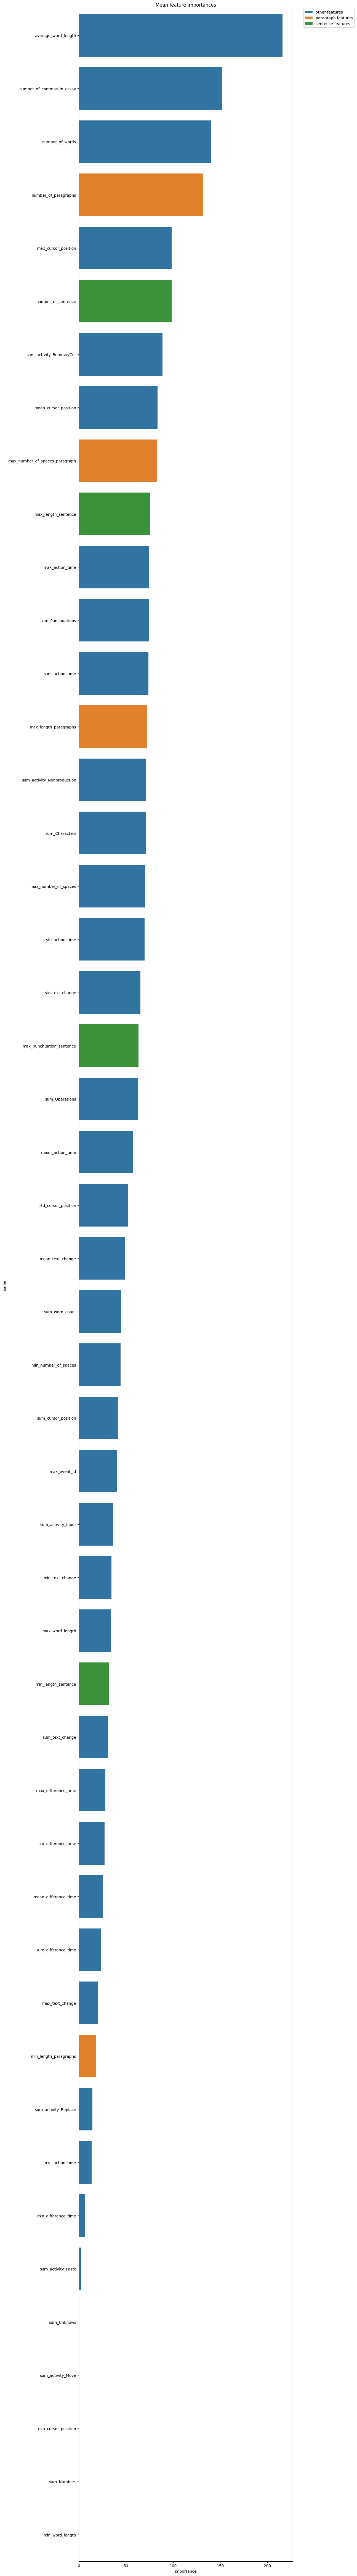

In [152]:
feature_importances_values = np.asarray([model.feature_importances_ for model in models_dict.values()]).mean(axis=0)
feature_importance_df = pd.DataFrame({'name': train_postprocessed_df.columns, 'importance': feature_importances_values})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
feature_importance_df['group'] = feature_importance_df['name'].apply(
    lambda x: 'sentence features' if 'sent' in x else 'paragraph features' if 'paragraph' in x else 'other features')

plt.figure(figsize=(10, 120))
ax = sns.barplot(data=feature_importance_df, x='importance', y='name', hue='group', dodge=False)
ax.set_title(f"Mean feature importances")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [127]:
# model = GradientBoostingRegressor(
#     n_estimators=300,
#     learning_rate=0.01,
#     max_depth=10,
#     min_samples_split=3,
#     min_samples_leaf=5,
#     subsample=0.9,
#     random_state=42
# )
model = RandomForestRegressor(
    n_estimators=3000,
    max_features='sqrt',
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=42
)

In [128]:
results = performCrossValidation(model,train_postprocessed_df,train_logs_df,y,aggregation=True)

In [129]:
results

,test_score,train_score
0,0.649490,0.253700
1,0.627939,0.255843
2,0.671990,0.250624
3,0.682845,0.251077
4,0.612596,0.257103
5,0.689173,0.251917


In [ ]:
model.fit(train_postprocessed_df,y)

In [ ]:
dataset_train = makePredictions(model,train_postprocessed_df,train_logs_df,aggregation=True)

In [ ]:
dataset_test = makePredictions(model,test_postprocessed_df,test_logs_df,aggregation=True) 

In [ ]:
mean_squared_error(y,dataset_train)

In [ ]:
# For submission
dataset_test["y_pred"].to_csv("submission.csv")

# For Model Optimization

In [ ]:
model,params = getModel("RandomForestRegressor")

In [ ]:
# scores = performCrossValidation(model,train_processed_df,train_logs_df,y)
model,results = perfromGridSearch(model,params,train_postprocessed_df,train_logs_df,y,results=True,aggregation=True)

In [ ]:
# model.fit(train_processed_df,y)
dataset_train = makePredictions(model,train_postprocessed_df,train_logs_df,aggregation=True)

In [ ]:
dataset_test = makePredictions(model,test_processed_df,test_logs_df,aggregation=True)

In [ ]:
dataset_train.to_csv("train.csv")

In [ ]:
mean_squared_error(dataset_train["y_true"],dataset_train["y_pred"])

In [ ]:
dataset_test["y_pred"].to_csv("submission.csv")

# Optimize with Optuna

In [ ]:
def objective(trial):
    model,params = getModel("RandomForestRegressor",optuna=True,trial=trial)
    score = performKfoldScore(model,train_processed_df,train_logs_df,y,k=3,optuna = True,trial = trial)
    params[0]['n_jobs']=[-1]
    return score
    

In [ ]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
    storage = "sqlite:///linking-writing-process-to-writing-quality.db",
    study_name = "RandomForest"
)
study.optimize(objective, n_trials=20)